In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

We set up the basic settings for file paths, nside, and lmax here.

In [3]:
config = {
    'binfile': 'planck_spectra/binused.dat',
    'map_dir': '/tigress/zequnl/cmb/data/planck/maps/PR2/frequencyMaps',
    'mask_dir': '/tigress/zequnl/cmb/data/planck/maps/PR2/maskMaps/',
    'nside': 2048,
    'lmax': 2508,
    'niter': 0
}

In [4]:
binleft, binright = np.arange(2,config['lmax']+1), np.arange(2,config['lmax']+1)
# set up NaMaster bins (bins weighted as D_ell as specified by Planck)
bpws_ell = np.arange(config['lmax']+1)
bpws = bpws_ell - 2 #Array of bandpower indices
bpws[bpws < 0] = -1 # our goal is to index ells 2-2509, and set ell=0,1 to -1.
weights = np.ones_like(bpws)

b = nmt.NmtBin(config['nside'], bpws=bpws, ells=bpws_ell, weights=weights, lmax=config['lmax'])
ells = b.get_effective_ells()

# compute and store the pixel window
pixel_window_T, pixel_window_P = hp.sphtfunc.pixwin(config['nside'], pol=True)
pixel_window_T = pixel_window_T[:3*config['lmax']] # NaMaster computes up to 3*nside
pixel_window_P = pixel_window_P[:3*config['lmax']]

In [5]:
def load_beam(freq1, freq2):
    if float(freq1) > float(freq2):
        beam_filename = f'planck_beam/beam_probably_used_in_2015_likelihood_{freq2}hm1x{freq1}hm2.dat.dat'
    else:
        beam_filename = f'planck_beam/beam_probably_used_in_2015_likelihood_{freq1}hm1x{freq2}hm2.dat.dat'
    beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
    Bl = np.zeros(3*config['nside'])
    Bl[beam_ell.astype(int)] = beam
    return Bl

def load_mask(freq):
    """returns mask tuple, (temperature, polarization, polarization)"""
    maskT = hp.read_map(
        config['mask_dir'] +
            f'/COM_Mask_Likelihood-temperature-{freq}_2048_R2.00.fits',
        verbose=False)
    maskP = hp.read_map(
        config['mask_dir'] + 
        f'/COM_Mask_Likelihood-polarization-{freq}_2048_R2.00.fits',
        verbose=False)
    return (maskT, maskP, maskP)

def load_map(freq, split):
    mfile = config['map_dir'] + f'/HFI_SkyMap_{freq}_2048_R2.02_halfmission-{split}.fits'
    return [
        hp.read_map(mfile, field=0, verbose=False), # I
        hp.read_map(mfile, field=1, verbose=False), # Q
        hp.read_map(mfile, field=2, verbose=False)] # U

In [6]:
def subtract_mono_di(map_in, mask_in, mono_fac=1.0, 
                     sub_dipole=True, verbose=True):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    if verbose: print('mono:', mono, ', dipole:', dipole)
    m = map_in.copy()
    npix = hp.nside2npix(config['nside'])
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize): # adapted from healpy
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(config['nside'], ipix, False)
        if sub_dipole:
            m.flat[ipix] -= dipole[0] * x
            m.flat[ipix] -= dipole[1] * y
            m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono * mono_fac  # MODIFY FACTOR
    return m

In [7]:
def load_bad_pix(freq, split):
    mfile = config['map_dir'] + f'/HFI_SkyMap_{freq}_2048_R2.02_halfmission-{split}.fits'
    hits = hp.read_map(mfile, field=3, verbose=False)
    bad = (hits == 0)
    return bad

## brief detour (can skip)

From the FITS header:
```
TTYPE1  = 'I_STOKES'           /                                    
TTYPE2  = 'Q_STOKES'           /
TTYPE3  = 'U_STOKES'           /
TTYPE4  = 'HITS    '           /
TTYPE5  = 'II_COV  '           /
TTYPE6  = 'IQ_COV  '           /
TTYPE7  = 'IU_COV  '           /
TTYPE8  = 'QQ_COV  '           /
TTYPE9  = 'QU_COV  '           /
TTYPE10 = 'UU_COV  '           /  
```
We might try to glean where the missing pixels are from `II_COV` and `UU_COV` instead of `HITS`. Below, we confirm that they lead to the same missing pixels.

In [8]:
mfile = config['map_dir'] + f'/HFI_SkyMap_{143}_2048_R2.02_halfmission-{1}.fits'
HITS = hp.read_map(mfile, field=3, verbose=False)
II_COV = hp.read_map(mfile, field=4, verbose=False)
UU_COV = hp.read_map(mfile, field=9, verbose=False)

print( 'HITS matches II_COV missing pixels:', 
      np.all( (HITS==0) == (II_COV==hp.UNSEEN) ) )
print( 'HITS matches UU_COV missing pixels:', 
      np.all( (HITS==0) == (UU_COV==hp.UNSEEN) ) )

/home/zequnl/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


HITS matches II_COV missing pixels: True
HITS matches UU_COV missing pixels: True


# compute 143x143

In [17]:
# read masks from dict or disk
freq1, freq2 = '143', '143'
split1, split2 = '1', '2'

mask1 = load_mask(freq1)
mask2 = load_mask(freq2)
map1 = load_map(freq1, split1)
map2 = load_map(freq2, split2)
Bl = load_beam(freq1, freq2)

# zero out the missing pixels in maps and masks
badpix1 = load_bad_pix(freq1, split1)
badpix2 = load_bad_pix(freq2, split2)

for i in range(3): # loop over IQU
    map1[i][badpix1] = 0.0
    map2[i][badpix2] = 0.0
    mask1[i][badpix1] = 0.0
    mask2[i][badpix2] = 0.0

map1[0] = subtract_mono_di(map1[0], mask1[0], sub_dipole=True)
map2[0] = subtract_mono_di(map2[0], mask2[0], sub_dipole=True)

/home/zequnl/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


mono: 3.998498131621588e-05 , dipole: [ 7.54449362e-06  7.15597791e-06 -2.72564914e-06]
mono: 3.99140102987874e-05 , dipole: [ 6.57762851e-06  6.49914808e-06 -2.01503630e-06]


In [18]:
# set up NaMaster objects
f1t = nmt.NmtField(mask1[0], [map1[0]],
    beam=(Bl*pixel_window_T), n_iter=config['niter'])
f2t = nmt.NmtField(mask2[0], [map2[0]],
    beam=(Bl*pixel_window_T), n_iter=config['niter'])
f1p = nmt.NmtField(mask1[1],[map1[1], map1[2]],
    beam=(Bl*pixel_window_P), n_iter=config['niter'])
f2p = nmt.NmtField(mask2[1],[map2[1], map2[2]],
    beam=(Bl*pixel_window_P), n_iter=config['niter'])

In [19]:
%%time 
w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(f1t, f2t, b, n_iter=config['niter'])
w1=nmt.NmtWorkspace()
w1.compute_coupling_matrix(f1t, f2p, b, n_iter=config['niter'])
w2=nmt.NmtWorkspace()
w2.compute_coupling_matrix(f1p, f2p, b, n_iter=config['niter'])

CPU times: user 42min 50s, sys: 46.4 s, total: 43min 37s
Wall time: 6min 3s


In [20]:
def compute_master(f_a, f_b, wsp) :
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [21]:
# put it into a nice dictionary
Cb={}
Cb['TT'] = compute_master(f1t, f2t, w0)[0]
spin1 = compute_master(f1t, f2p, w1)
Cb['TE'] = spin1[0]
Cb['TB'] = spin1[1]
spin2 = compute_master(f1p, f2p, w2)
Cb['EE'] = spin2[0]
Cb['EB'] = spin2[1]
Cb['BE'] = spin2[2]
Cb['BB'] = spin2[3]
spin1 = compute_master(f2t, f1p, w1)
Cb['ET']=spin1[0]
Cb['BT']=spin1[1]

The Planck analysis is done on unbinned spectra, which is subsequently binned here after mode decoupling.

In [22]:
def bin_spec(s):
    binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                              unpack=True, usecols=(0,1), dtype=((int), (int)))
    ell_sub_list = [ np.arange(l,r) for (l,r) in zip(binleft, binright+1) ]
    lb = np.array([np.sum(ell_sub) / len(ell_sub) for ell_sub in ell_sub_list])
    cl_from_zero = np.zeros(config['lmax']+1)
    cl_from_zero[ells.astype('int')] = s * 1e12
    weights = np.arange(config['lmax']+1) * (np.arange(config['lmax']+1) + 1)
    return lb, np.array([np.sum((weights * cl_from_zero)[ell_sub]
                  ) / np.sum(weights[ell_sub]) for ell_sub in ell_sub_list])

def bin_spec_dict(Cb):
    binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                              unpack=True, usecols=(0,1), dtype=((int), (int)))
    ell_sub_list = [ np.arange(l,r) for (l,r) in zip(binleft, binright+1) ]
    lb = np.array([np.sum(ell_sub) / len(ell_sub) for ell_sub in ell_sub_list])
    
    result = {}
    for spec_key in Cb:
        lb, result[spec_key] = bin_spec(Cb[spec_key])

    return lb, result

In [23]:
lb, Cb_binned = bin_spec_dict(Cb)

# Comparison

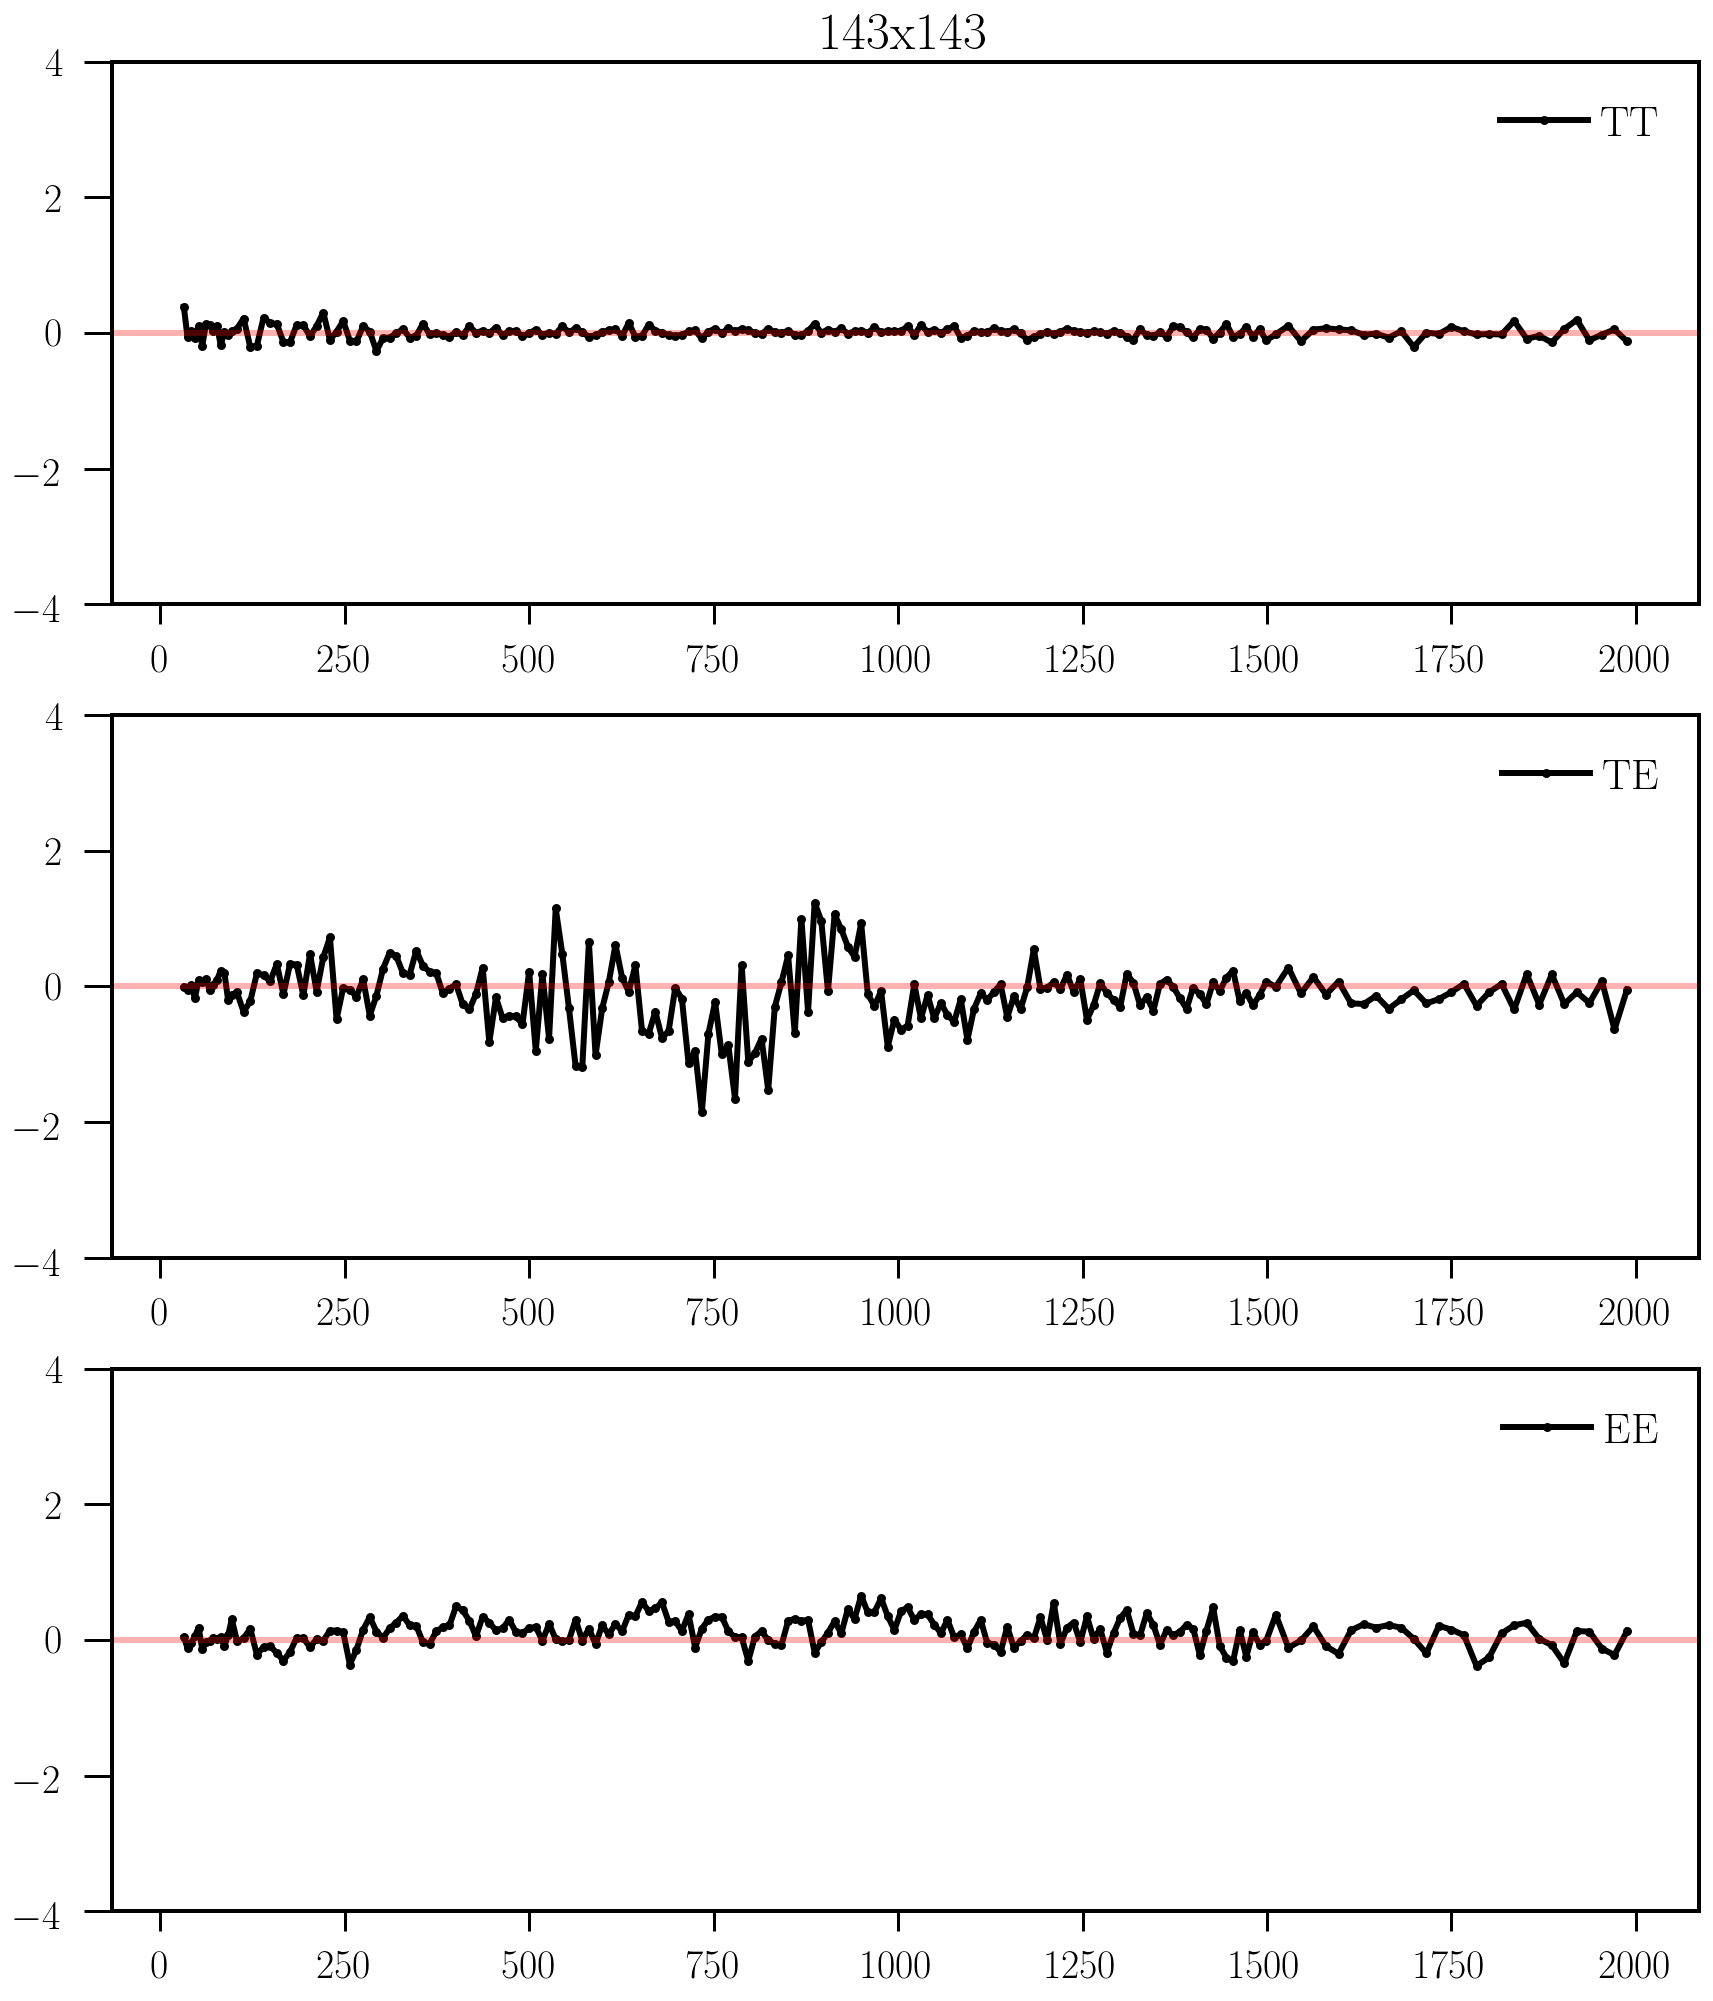

In [24]:
fig, axes = plt.subplots(3,1,figsize=(12,14))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{freq1}x{freq2}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)
    
    if spec != 'TE':
        s = Cb_binned[spec]
    else:
        s = ((Cb_binned['TE'] + Cb_binned['ET']))/2
        
        
    ref_filt = np.in1d(lb, l_ref)
    ax.plot(l_ref, (s[ref_filt] - (cl_ref)) / (error_ref), 
            'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylim(-4,4)
    ax.legend()
    
axes[0].set_title(f'{freq1}x{freq2}')

plt.tight_layout()